In [1]:
import pandas as pd
import numpy as np
import math

In [21]:
# read first x lines from a csv file and store them in da dataframe
df = pd.read_csv("dataset/BTCUSDT-bookTicker-2023-06-s", nrows=50000)

# remove column s from the dataframe
df = df.drop(columns=["s"])

In [22]:
# add a new column "mid_price" to the dataframe. The mid price is calculated as (b * B + a * A) / (B + A)
df["mid_price"] = (df["b"] * df["A"] + df["a"] * df["B"]) / (df["B"] + df["A"])

# add "spread" column to the dataframe. The spread is calculated as a - b
df["spread"] = (df["a"] - df["b"]).round(5)

# add "id_change" column to the dataframe. The id_change is calculated as u(t) - u(t-1)
df["id_change"] = df["u"] - df["u"].shift(1)

# add "log_return" column to the dataframe. The log return is calculated as log(mid_price[t] / mid_price[t-1])
df["log_return"] = df["mid_price"].apply(lambda x: math.log(x)) - df["mid_price"].shift(1).apply(lambda x: math.log(x))

# round log_return to 4 decimal places and take -0.0 as 0.0
df["log_return"] = df["log_return"].round(4).apply(lambda x: 0.0 if x == -0.0 else x)

# drop a and b columns from the dataframe
df = df.drop(columns=["a", "b", "u", "mid_price"])

# drop rows with NaN values
df = df.dropna()
print(df.head())

                         time        B        A  spread  id_change  log_return
1  2023-06-01 00:00:00.003607  9.33901  1.67038    0.01        1.0         0.0
2  2023-06-01 00:00:00.005132  9.33901  1.66972    0.01        2.0         0.0
3  2023-06-01 00:00:00.007374  8.64481  1.66972    0.01       10.0         0.0
4  2023-06-01 00:00:00.009193  8.64372  1.66972    0.01       34.0         0.0
5  2023-06-01 00:00:00.011579  8.64372  1.66708    0.01       31.0         0.0


array([[<AxesSubplot:title={'center':'B'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'spread'}>,
        <AxesSubplot:title={'center':'id_change'}>],
       [<AxesSubplot:title={'center':'log_return'}>, <AxesSubplot:>]],
      dtype=object)

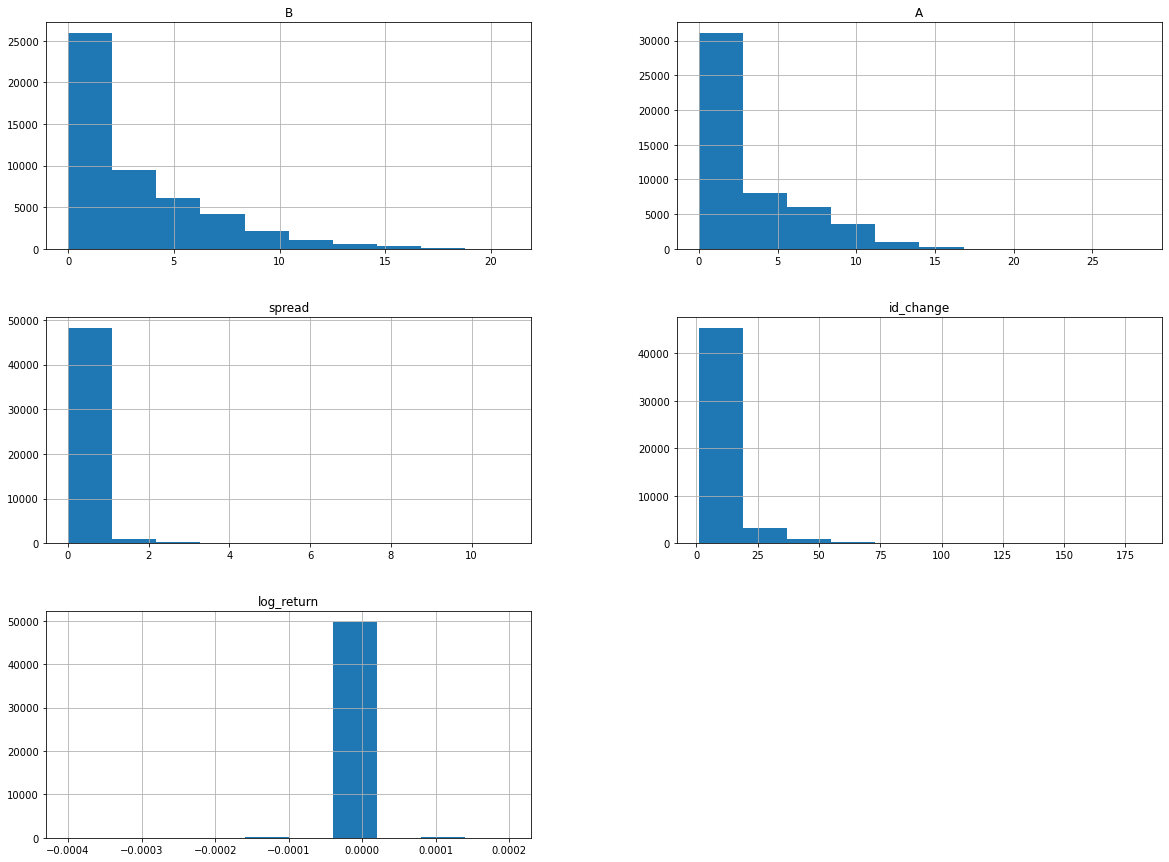

In [23]:
# plot the distribution of all columns in subplots
df.hist(bins=10, figsize=(20, 15))

In [24]:
# save the dataframe to a csv file
df.to_csv("dataset/ticker/BTCUSDT-bookTicker-2023-06-s-50k-processed.csv", index=False)

In [2]:
name = "Ticker_FEDformer_random_modes64_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_'Exp'_0"
trues = np.load("./results/%s/true.npy" % name)
pred = np.load("./results/%s/pred.npy" % name)

In [6]:
pred.shape

(9888, 96, 5)